In [33]:
# Package installation

!pip install numpy
!pip install matplotlib

In [34]:
# Package imports

import matplotlib.pyplot as plt
import numpy as np
import os 
import sys
from PIL import Image
import random
import cv2
import functools
from copy import deepcopy
from sklearn.linear_model import LogisticRegression

In [35]:
# reduce size of images import os, sys
new_image_height = 40
new_image_width = 40
old_directory = "dataset/Edited"
new_directory = "dataset/Reduced"

In [36]:


c = 0
for file in os.listdir(old_directory) :
    if(file != ".DS_Store") :
        old_image_path = os.path.join(old_directory, file)
        old_image = Image.open(old_image_path)
        old_image = old_image.resize((new_image_height, new_image_width), Image.ANTIALIAS)
        
        new_image_path = os.path.join(new_directory, file)
        old_image.save(new_image_path)

In [37]:
# get all images from the reduced dataset, and construct the dataset
Y = [] # labels
Y_values = {} # mapping from person name to number
Y_inverse_values = {} # mapping from number to person name, to be used during prediction

X = [] # training dataset

for file in os.listdir(new_directory) :
    if(file != ".DS_Store") :
        # for X
        im = cv2.imread(os.path.join(new_directory, file))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = im.flatten()
        X.append(im)

        # for Y
        label_name = file.split("_")[0]
        if(label_name not in Y_values) :
            new_val = len(Y_values) + 1
            Y_values[label_name] = new_val
            Y_inverse_values[new_val] = label_name
        Y.append(Y_values[label_name])
        
X = np.array(X)
Y = np.array(Y)

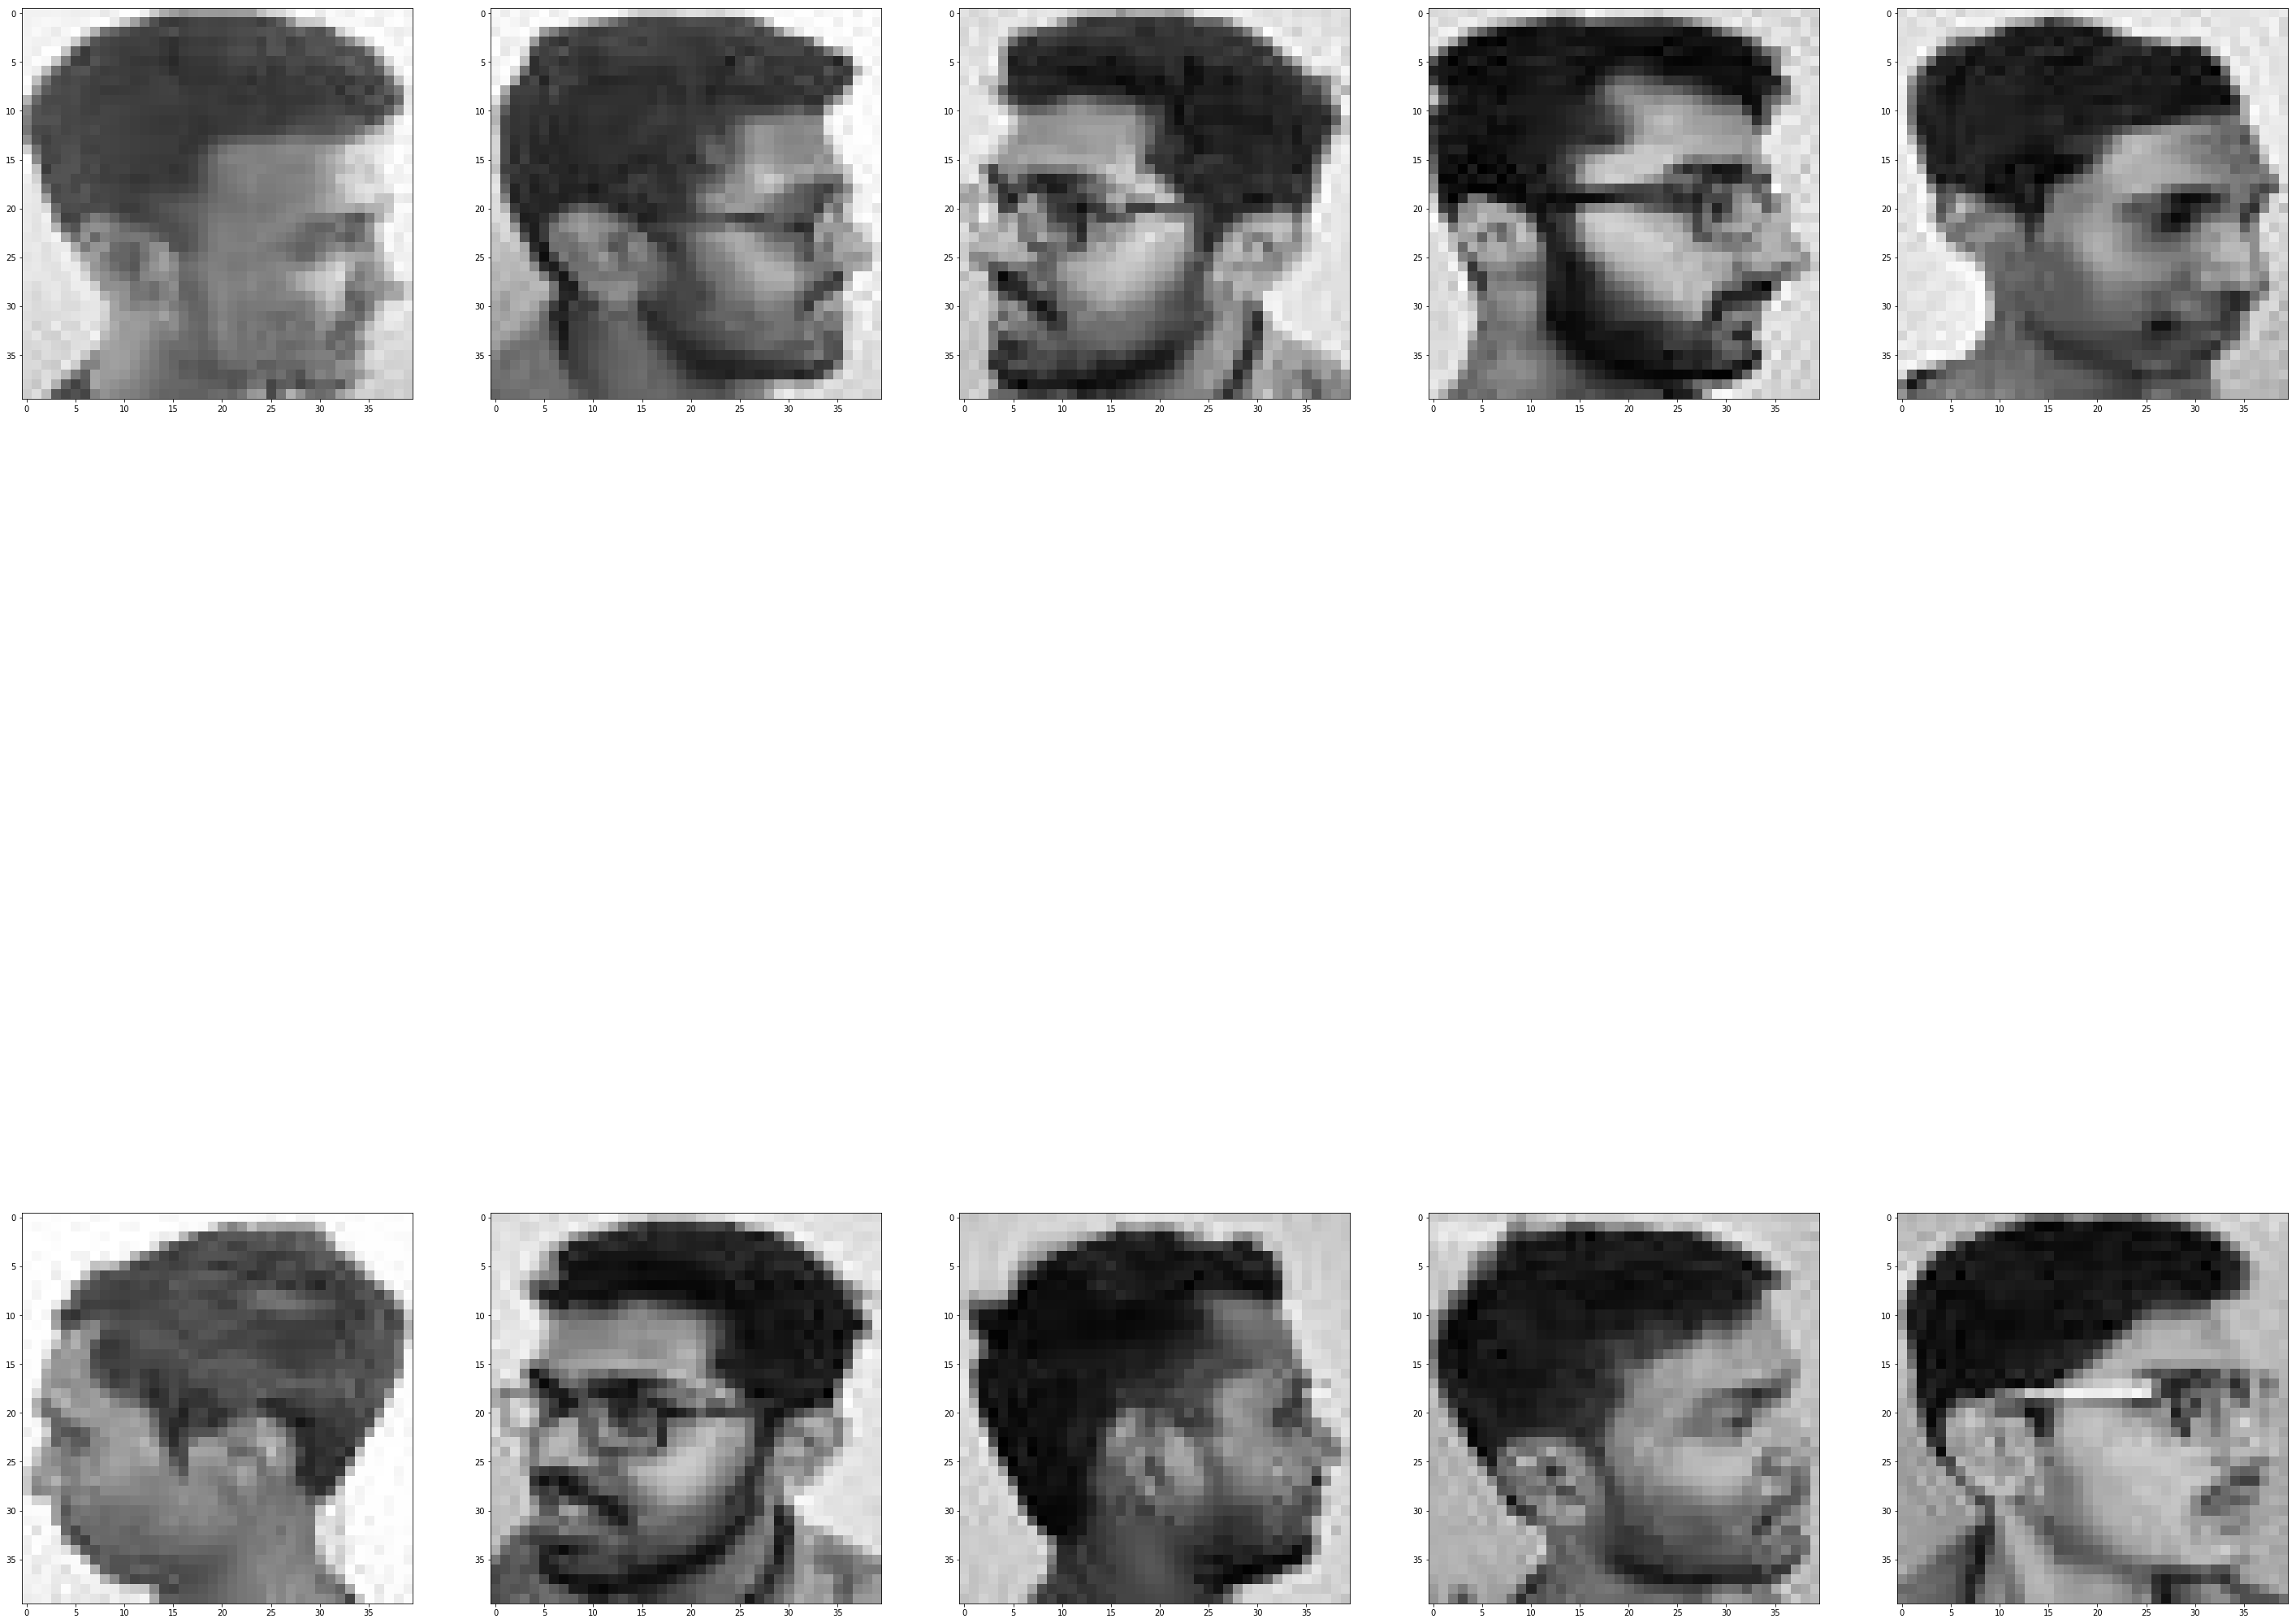

In [38]:
# display random 10 images
fig = plt.figure()

random_indices = random.sample(range(0, X.shape[0]), 10)
for i in range(len(random_indices)) :
    tmp = X[random_indices[i]].reshape(new_image_height, new_image_width)
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)) # need to convert to RGB, else gives yellowish image

In [39]:
# mean normalization
mean_intensities = np.mean(X, axis=0)

In [40]:
# split into training and testing data
X_train = []
X_test = []
Y_train = []
Y_test = []

training_perc = 75 
sample_size = int((training_perc / float(100)) * X.shape[0])
training_indices = random.sample(range(0, X.shape[0]), sample_size)
for i in range(X.shape[0]) :
    if(i in training_indices) :
        X_train.append(X[i])
        Y_train.append(Y[i])
    else :
        X_test.append(X[i])
        Y_test.append(Y[i])
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [41]:
mean_intensities = np.mean(X_train)
X_train = X_train - mean_intensities

In [42]:
X_test_original = deepcopy(X_test)
mean_intensities = np.mean(X_test)
X_test = X_test - mean_intensities

In [43]:
# finding covariance matrix 
cov_matrix = (1 / float(X_train.shape[0])) * np.dot(np.transpose(X_train), X_train)

In [44]:
# finding best K values

u, s, v = np.linalg.svd(cov_matrix)
total_sum = 0
for i in range(s.shape[0]) :
    total_sum = total_sum + s[i]
prefix_sum = 0
for i in range(1600) :
    prefix_sum = prefix_sum + s[i]
    val = float(prefix_sum) / float(total_sum)
    if(val >= 0.99) :
        K = i + 1
        break

In [45]:
best_eigen_vectors = []
for i in range(K) :
    best_eigen_vectors.append(u[:, i])
best_eigen_vectors = np.array(best_eigen_vectors)

In [46]:
best_eigen_vectors.shape

(44, 1600)

In [47]:
X_train.shape

(52, 1600)

In [48]:
# getting the eigen faces
eigen_faces = np.dot(X_train, np.transpose(best_eigen_vectors))

In [49]:
# for testing data => already done mean normalization

projected_data = np.dot(X_test, np.transpose(best_eigen_vectors))

In [50]:
# prediction

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)

predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, Y_test)
print(score)

0.7777777777777778


/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [51]:


# prediction

logisticRegr = LogisticRegression()
logisticRegr.fit(eigen_faces, Y_train)

predictions = logisticRegr.predict(projected_data)

score = logisticRegr.score(projected_data, Y_test)
print(score)

0.7777777777777778


/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [52]:
predictions

array([ 1,  2,  3,  1,  3,  1,  9,  5,  1,  5,  2,  7,  2,  7,  8,  7, 10,
       10])

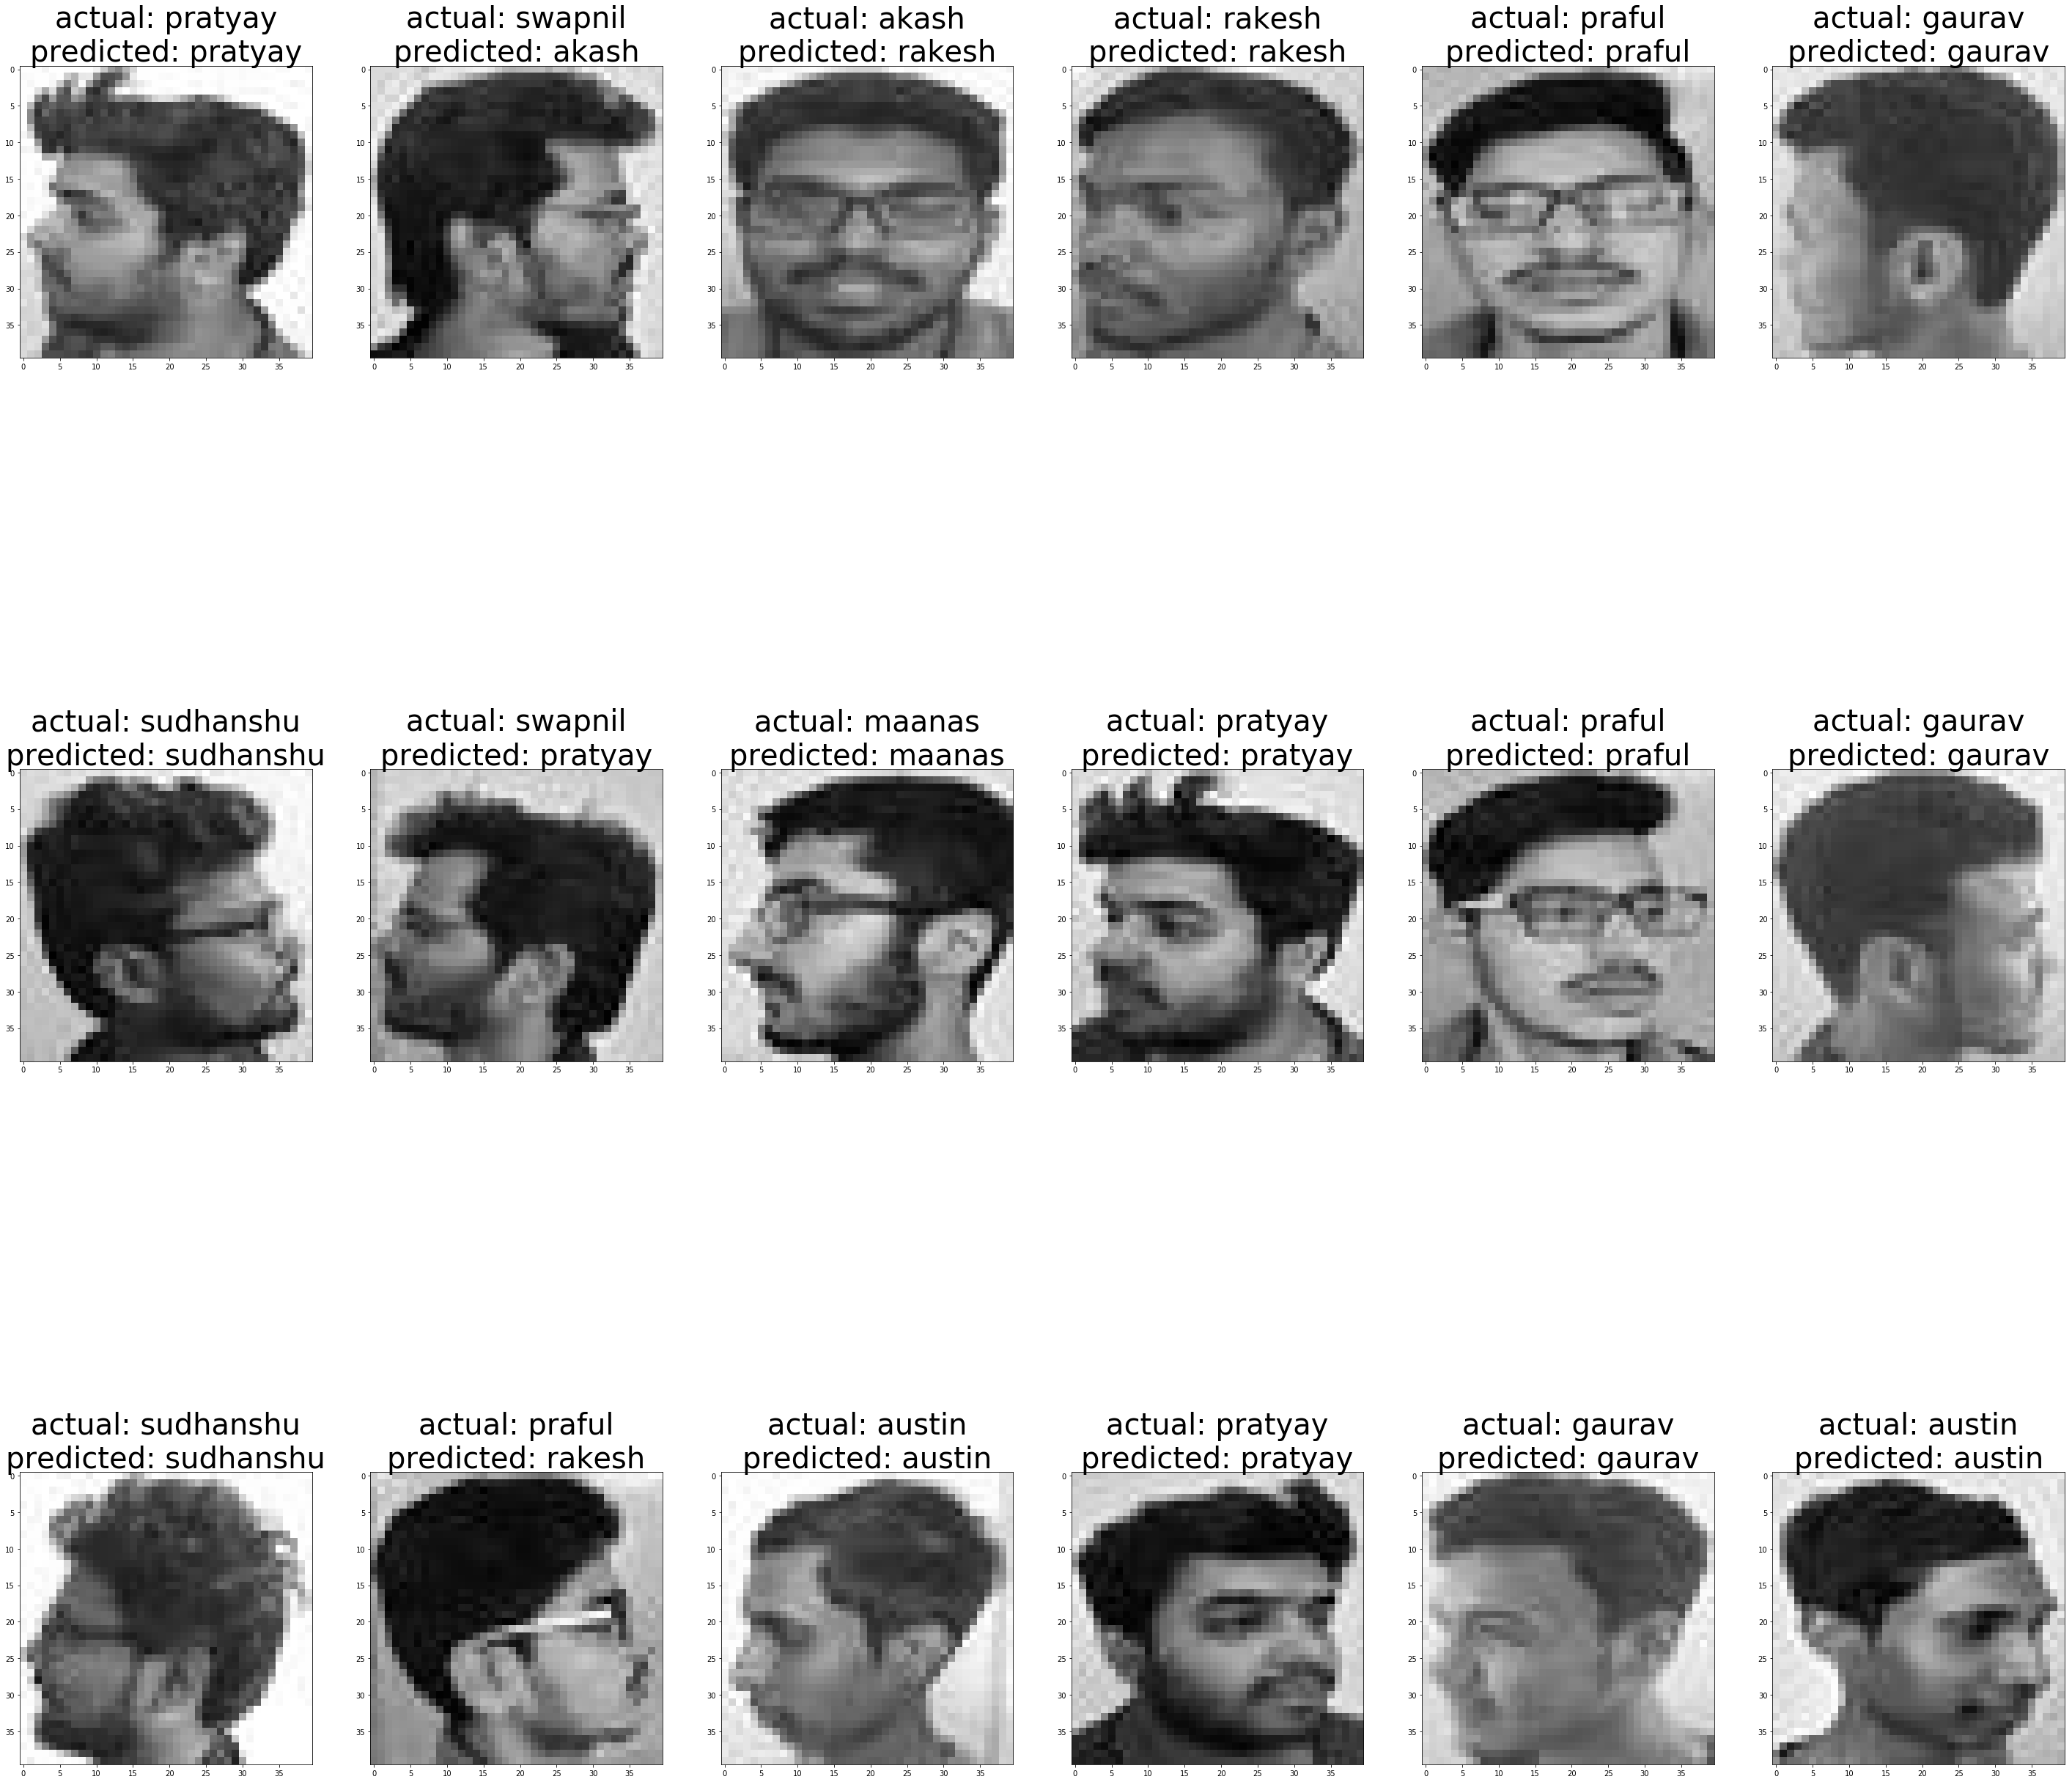

In [53]:
# show prediction v/s actual

fig = plt.figure()
plt.rcParams['figure.figsize'] = [50, 50]
k = 1
for i in range(6) :
    for j in range(3) :
        tmp = deepcopy(X_test_original[6 * j + i])
        tmp = tmp.reshape(new_image_height, new_image_width)
        plt.subplot(3, 6, k)
        
        predicted_label = Y_inverse_values[predictions[6 * j + i]]
        actual_label = Y_inverse_values[Y_test[6 * j + i]]
        title = "actual: " + actual_label + "\npredicted: " + predicted_label 
        
        plt.title(title, fontsize=40)
        k = k + 1
        plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)) # need to convert to RGB, else gives yellowish image

In [54]:
# prediction using euclidean distnace

predictions = []

for i in range(projected_data.shape[0]) :
    min_distance = -1
    for j in range(eigen_faces.shape[0]) :
        distance = np.linalg.norm(eigen_faces[j] - projected_data[i]) 
        if(min_distance == -1 or min_distance > distance) :
            min_distance = distance
            label = Y_train[j]
    predictions.append(label)

In [55]:
predictions

[6, 2, 3, 6, 3, 1, 1, 5, 1, 5, 2, 7, 2, 7, 8, 7, 10, 10]

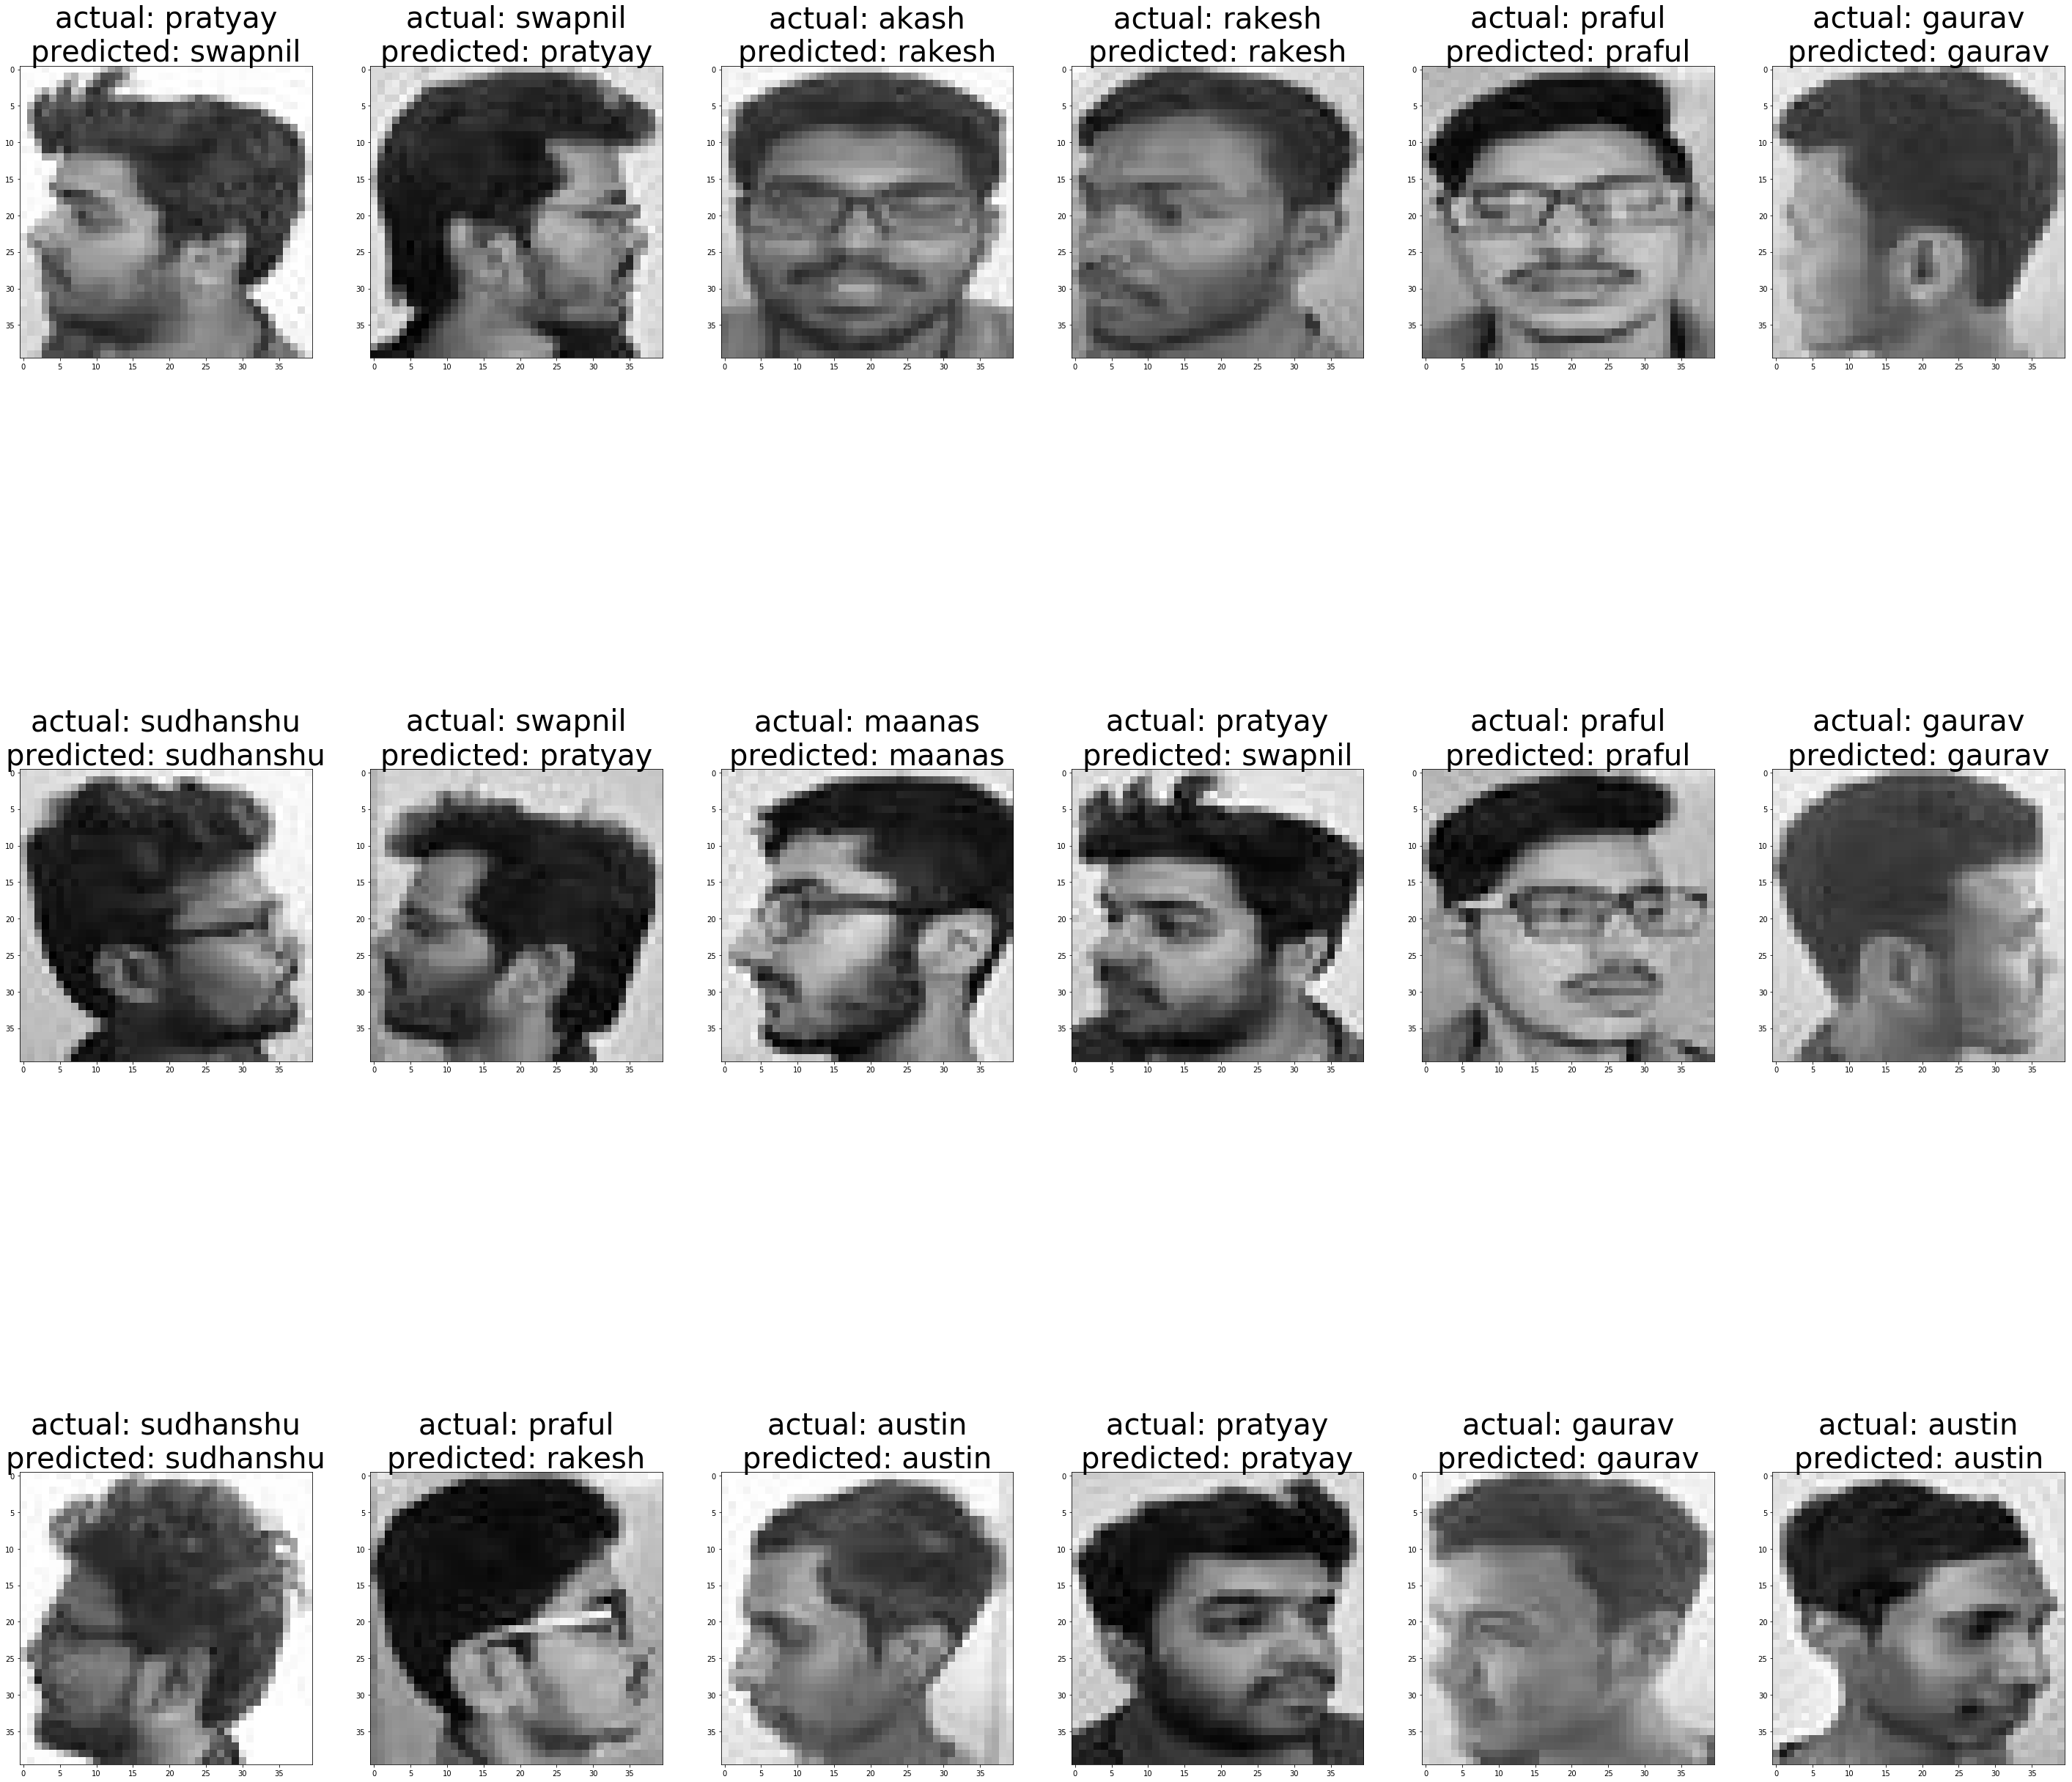

In [56]:
# show prediction v/s actual

total_correct = 0

fig = plt.figure()
plt.rcParams['figure.figsize'] = [50, 50]
k = 1
for i in range(6) :
    for j in range(3) :
        tmp = deepcopy(X_test_original[6 * j + i])
        tmp = tmp.reshape(new_image_height, new_image_width)
        plt.subplot(3, 6, k)
        
        predicted_label = Y_inverse_values[predictions[6 * j + i]]
        actual_label = Y_inverse_values[Y_test[6 * j + i]]
        
        if(predicted_label == actual_label) :
            total_correct += 1
            
        title = "actual: " + actual_label + "\npredicted: " + predicted_label 
        
        plt.title(title, fontsize=40)
        k = k + 1
        plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)) # need to convert to RGB, else gives yellowish image

In [57]:
print("percent accuracy : ", (total_correct / X_test.shape[0]) * 100)

percent accuracy :  66.66666666666666


Predicted values using Logistic regression: [1, 2, 3, 1, 3, 1, 9, 5, 1, 5, 2, 7, 2, 7, 8, 7, 10, 10]
Accuracy: 77.7%

Predicted values using euclidean distance: [6, 2, 3, 6, 3, 1, 1, 5, 1, 5, 2, 7, 2, 7, 8, 7, 10, 10]
Accuracy: 66.66%